# VAE for Ising QuCumber Data

Trains a variational auto-encoder from training data representing 10,000 draws from the ground state of the transverse-field Ising Hamiltonian with 10 sites at the critical point J = h = 1. The data comes from the QuCumber tutorial:

https://qucumber.readthedocs.io/en/stable/_examples/Tutorial1_TrainPosRealWaveFunction/tutorial_quantum_ising.html?highlight=tfi#

The Hamiltonian is given by:

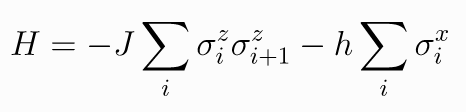

In [23]:
import pandas as pd

In [24]:
is_data = pd.read_table('/Users/tuckerkj/Google Drive/Research/QML/data/quc_examples/Tutorial1_TrainPosRealWaveFunction/tfim1d_data.txt', delimiter=' ', usecols=range(10)).values
is_train = is_data[0:7999]
is_test = is_data[8000:9999]

In [25]:
is_train.shape

(7999, 10)

In [26]:
original_dim = is_train.shape[1]

In [208]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 100
batch_size = 128
latent_dim = 4
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 10)           0                                            
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 100)          1100        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 4)            404         dense_52[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 4)            404         dense_52[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

In [209]:
models = (encoder, decoder)
data = (is_test, y_test)

In [210]:
# VAE loss = mse_loss or xent_loss + kl_loss
    #if args.mse:
        #reconstruction_loss = mse(inputs, outputs)
    #else:
reconstruction_loss = binary_crossentropy(inputs,
                                          outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,
            to_file='vae_mlp.png',
            show_shapes=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 10)                0         
_________________________________________________________________
encoder (Model)              [(None, 4), (None, 4), (N 1908      
_________________________________________________________________
decoder (Model)              (None, 10)                1510      
Total params: 3,418
Trainable params: 3,418
Non-trainable params: 0
_________________________________________________________________


In [211]:
#if args.weights:
        #vae.load_weights(args.weights)
    #else:
        # train the autoencoder
vae.fit(is_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(is_test, None))
#vae.save_weights('vae_mlp_mnist.h5')

Train on 7999 samples, validate on 1999 samples
Epoch 1/50
7999/7999 [==============================] - 2s 256us/step - loss: 6.9778 - val_loss: 6.8564
Epoch 2/50
7999/7999 [==============================] - 0s 16us/step - loss: 6.5860 - val_loss: 6.2195
Epoch 3/50
7999/7999 [==============================] - 0s 16us/step - loss: 6.0625 - val_loss: 5.9938
Epoch 4/50
7999/7999 [==============================] - 0s 17us/step - loss: 5.8382 - val_loss: 5.8678
Epoch 5/50
7999/7999 [==============================] - 0s 17us/step - loss: 5.7741 - val_loss: 5.8372
Epoch 6/50
7999/7999 [==============================] - 0s 17us/step - loss: 5.7454 - val_loss: 5.7284
Epoch 7/50
7999/7999 [==============================] - 0s 16us/step - loss: 5.6643 - val_loss: 5.6561
Epoch 8/50
7999/7999 [==============================] - 0s 24us/step - loss: 5.6220 - val_loss: 5.6257
Epoch 9/50
7999/7999 [==============================] - 0s 17us/step - loss: 5.5560 - val_loss: 5.5873
Epoch 10/50
7999/7999 [=

In [31]:
def bit_array(a):
    aa = []
    for c in a:
        if c == '0':
            aa.append(0)
        else:
            aa.append(1)
        
    return np.array(aa)

In [182]:
import math
def get_psi_vae(vae):
    nc = int(vae.input.shape[-1])
    norm = 0
    psi = []
    for d in range(2**nc):
        dbin = bit_array(np.binary_repr(d, width=10))
        val = np.exp(-0.5*vae.evaluate(dbin.reshape([1,-1]),steps=100))
        psi.append(val)
        norm = norm + val*val
    norm = math.sqrt(norm)
    
    for ii in range(len(psi)):
        psi[ii] = psi[ii]/norm
        
    return np.array(psi)

In [144]:
d = 1023
dbin = bit_array(np.binary_repr(d, width=10))
dbin = 0.5*dbin
val = np.exp(-0.5*vae.evaluate(dbin.reshape([1,-1])))

1/1 [==============================] - 0s 950us/step


In [171]:
vae.evaluate(dbin.reshape([1,-1]),steps=1000)

1000/1000 [==============================] - 1s 530us/step


9.510357795715333

In [212]:
psi = get_psi_vae(vae)

100/100 [==============================] - 0s 587us/step


100/100 [==============================] - 0s 549us/step


100/100 [==============================] - 0s 559us/step


100/100 [==============================] - 0s 477us/step


In [200]:
print(psi)

[0.28880826 0.13985712 0.0874206  ... 0.10069233 0.13424481 0.24866285]


In [185]:
np.dot(psi, psi)

1.0000000000000007

In [186]:
np.sum(psi**2)

1.0000000000000009

In [213]:
# Save the wave function
np.savetxt('/Users/tuckerkj/Google Drive/Research/QML/data/quc_examples/Tutorial1_TrainPosRealWaveFunction/ld_results/vae_psi_test.txt', psi)

In [93]:
# Save the model
vae.save('/Users/tuckerkj/Google Drive/Research/QML/data/quc_examples/Tutorial1_TrainPosRealWaveFunction/ld_results/vae_32d.h5')

In [319]:
def plot_qvae_results(models, z_min, z_max, frame_size = 0, fig_size = 10, fig_bkgrnd = 1):
    """Plots spins as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        frame_size: width of space between spin images
    """

    encoder, decoder = models
    #x_test, y_test = data
    #os.makedirs(model_name, exist_ok=True)

    #filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    #z_mean, _, _ = encoder.predict(x_test,
    #                               batch_size=batch_size)
    #plt.figure(figsize=(12, 10))
    #plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    #plt.colorbar()
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    #plt.savefig(filename)
    #plt.show()

    #filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 10
    figure = np.zeros(((frame_size + digit_size) * n + frame_size,
                       (frame_size + digit_size) * n + frame_size)) + fig_bkgrnd
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(z_min[0], z_max[0], n)
    grid_y = np.linspace(z_min[1], z_max[1], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[0, xi, 2, yi]])
            x_decoded = decoder.predict(z_sample)
            #print(x_decoded[0].shape)
            digit = np.stack([x_decoded[0] for ii in range(10)]).reshape(digit_size, digit_size)
            figure[i * (frame_size + digit_size) + frame_size: (i + 1) * (digit_size + frame_size),
                   j * (frame_size + digit_size) + frame_size: (j + 1) * (digit_size + frame_size)] = digit

    plt.figure(figsize=(fig_size, fig_size))
    start_range = (digit_size + frame_size) // 2
    end_range = (n - 1) * (digit_size + frame_size) + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size + frame_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='gray', vmin=0, vmax=1)
    #plt.savefig(filename)
    plt.show()

In [38]:
def plot_qvae_latent(models, z):
    """Plots spins for the given 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        z (tuple): latent vector
    """

    encoder, decoder = models

    img_height = 10

    z_sample = np.array([z])
    x_decoded = decoder.predict(z_sample)
    spin_img = np.stack([x_decoded[0] for ii in range(img_height)]).reshape(img_height, img_height)

    #print(spin_img)

    plt.figure(figsize=(10, 4))
    plt.imshow(spin_img, cmap='gray', vmin=0, vmax=1)
    plt.show()

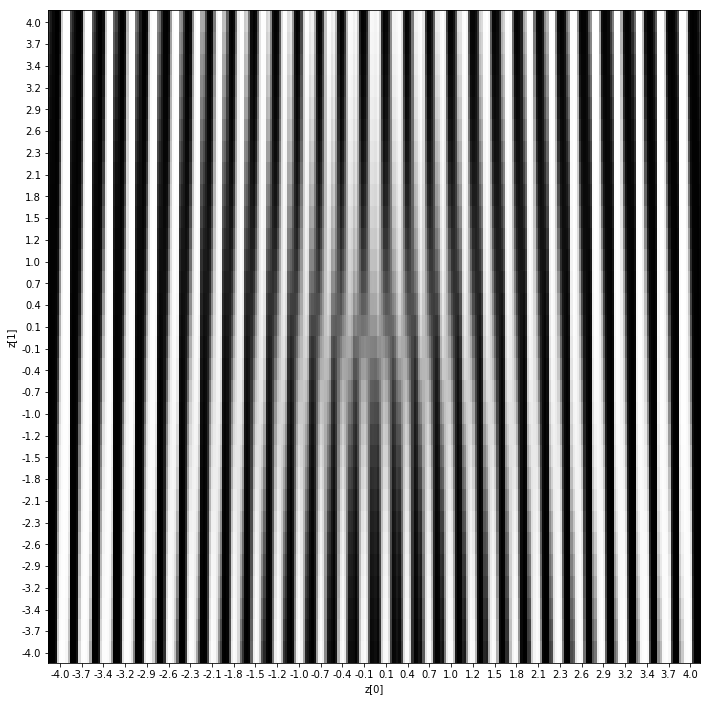

In [215]:
plot_qvae_results(models, [-4,-4], [4,4], 0, 12, 0.3) # 1st and 2nd

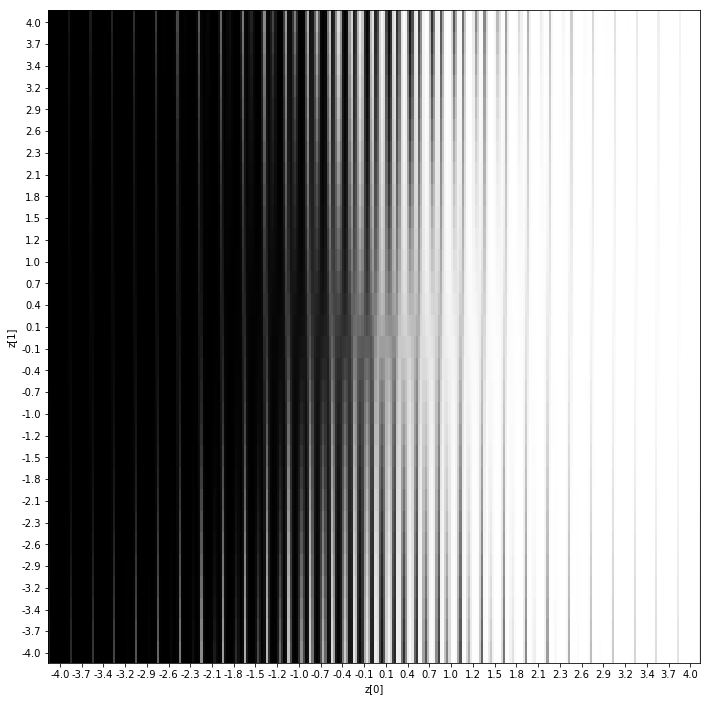

In [242]:
plot_qvae_results(models, [-4,-4], [4,4], 0, 12, 0.3) # 3rd and 4th

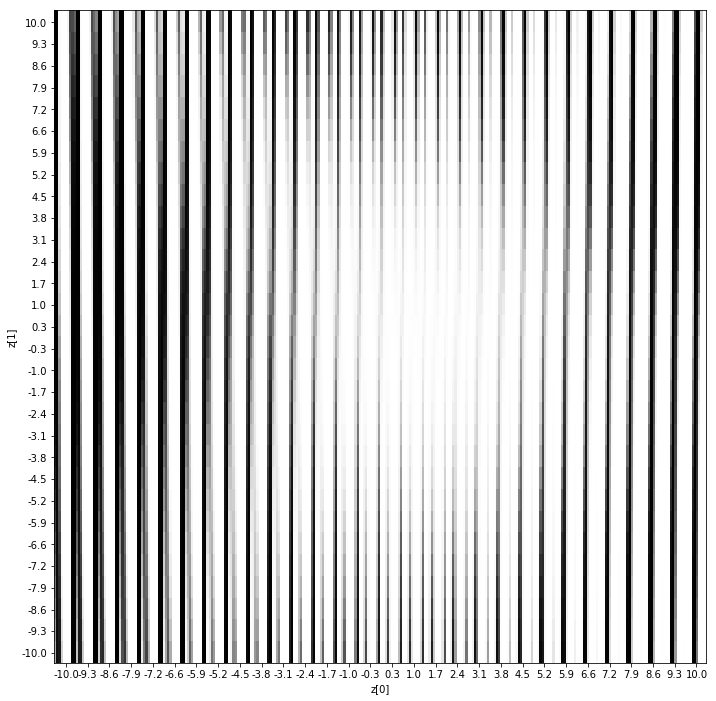

In [321]:
plot_qvae_results(models, [-10,-10], [10,10], 0, 12, 0.3) # 2nd and 4th

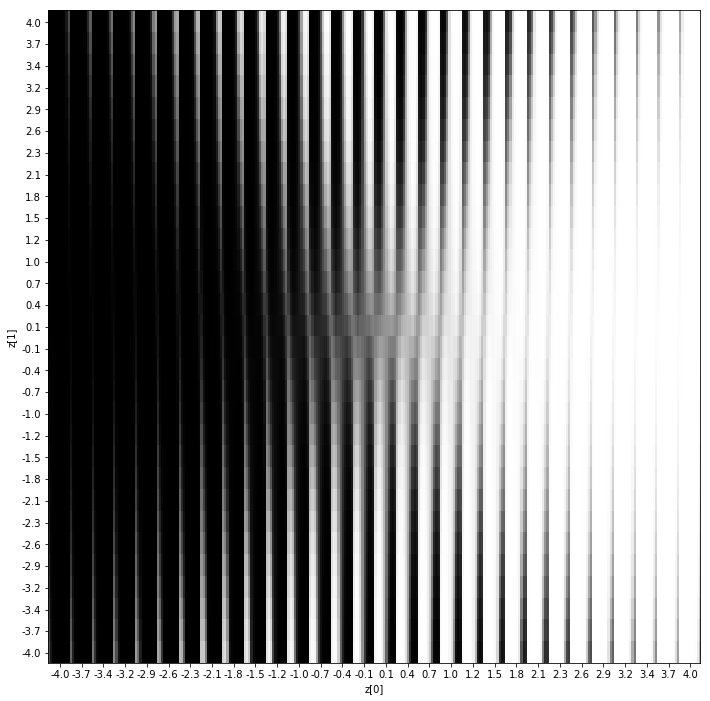

In [123]:
plot_qvae_results(models, [-4,-4], [4,4], 0, 12, 0.3)

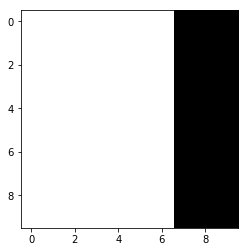

In [314]:
plot_qvae_latent(models, [100, -100, 10, -100])

In [46]:
a = np.array([1,2,3])

In [47]:
np.stack([a for i in range(3)])

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

# Keras VAE MNIST Example Script

In [6]:
'''Example of VAE on MNIST dataset using MLP
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1.
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [8]:
models = (encoder, decoder)
data = (x_test, y_test)

In [5]:
# VAE loss = mse_loss or xent_loss + kl_loss
    #if args.mse:
        #reconstruction_loss = mse(inputs, outputs)
    #else:
reconstruction_loss = binary_crossentropy(inputs,
                                          outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,
            to_file='vae_mlp.png',
            show_shapes=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [6]:
#if args.weights:
        #vae.load_weights(args.weights)
    #else:
        # train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
#vae.save_weights('vae_mlp_mnist.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 144us/step - loss: 196.9297 - val_loss: 172.2289
Epoch 2/50
60000/60000 [==============================] - 9s 152us/step - loss: 168.6761 - val_loss: 166.3563
Epoch 3/50
60000/60000 [==============================] - 9s 156us/step - loss: 164.8637 - val_loss: 163.7311
Epoch 4/50
60000/60000 [==============================] - 9s 153us/step - loss: 162.8747 - val_loss: 162.6889
Epoch 5/50
60000/60000 [==============================] - 10s 160us/step - loss: 161.4085 - val_loss: 160.8805
Epoch 6/50
60000/60000 [==============================] - 9s 150us/step - loss: 160.0384 - val_loss: 159.6267
Epoch 7/50
60000/60000 [==============================] - 9s 154us/step - loss: 158.8798 - val_loss: 158.7136
Epoch 8/50
60000/60000 [==============================] - 9s 155us/step - loss: 157.9147 - val_loss: 158.0184
Epoch 9/50
60000/60000 [==============================] - 9s 155us/st

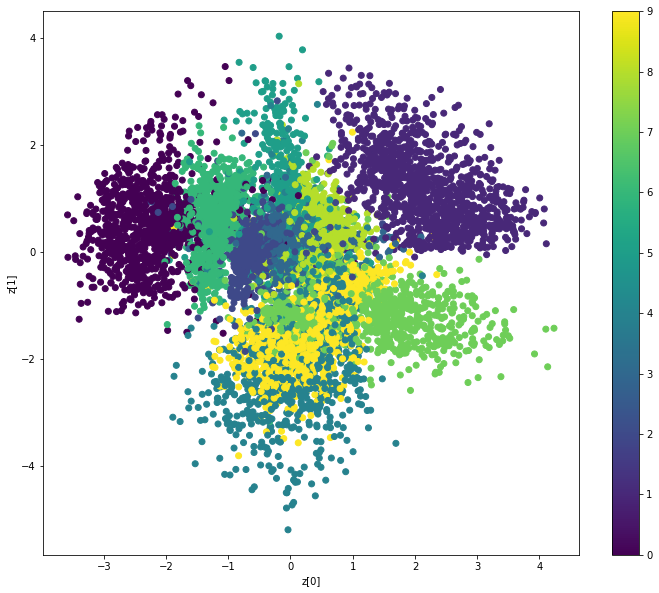

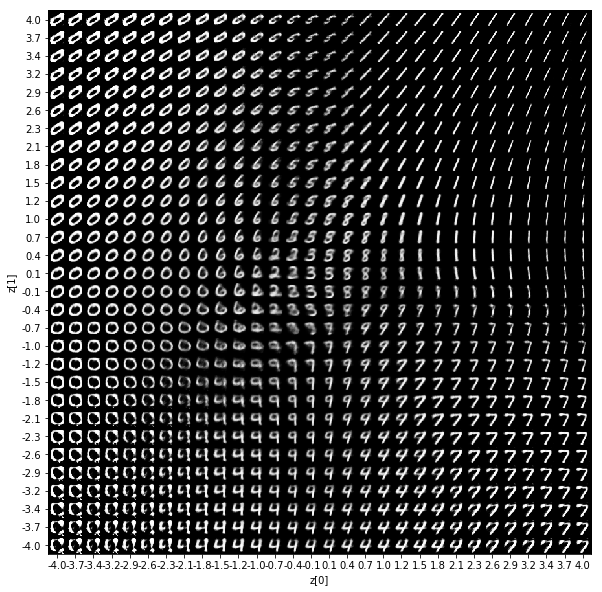

In [9]:
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")

# Keras MNIST Tutorial

In [22]:
from keras.layers import Input, LSTM, RepeatVector, Dense, Lambda, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
from keras import objectives
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K

In [54]:
batch_size = 100
original_dim = 28*28
intermediate_dim = 100
latent_dim = 10
epsilon_std = 1.0
epochs = 5

In [82]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 100
latent_dim = 2
epochs = 10

In [83]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [84]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling)([z_mean, z_log_sigma])

In [85]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [86]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [87]:
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [88]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [89]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 134us/step - loss: 0.2925 - val_loss: 0.2629
Epoch 2/10
60000/60000 [==============================] - 8s 130us/step - loss: 0.2631 - val_loss: 0.2628
Epoch 3/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.2631 - val_loss: 0.2628
Epoch 4/10
60000/60000 [==============================] - 8s 139us/step - loss: 0.2631 - val_loss: 0.2626
Epoch 5/10
60000/60000 [==============================] - 9s 152us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 6/10
60000/60000 [==============================] - 9s 142us/step - loss: 0.2630 - val_loss: 0.2628
Epoch 7/10
60000/60000 [==============================] - 8s 137us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 8/10
60000/60000 [==============================] - 8s 140us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 9/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.2630 - val_loss: 0.2

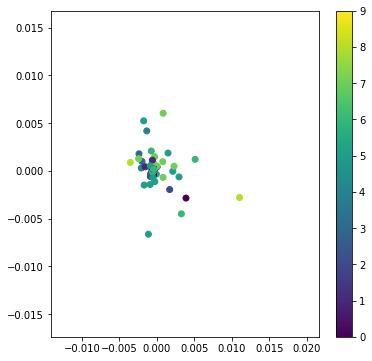

In [90]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

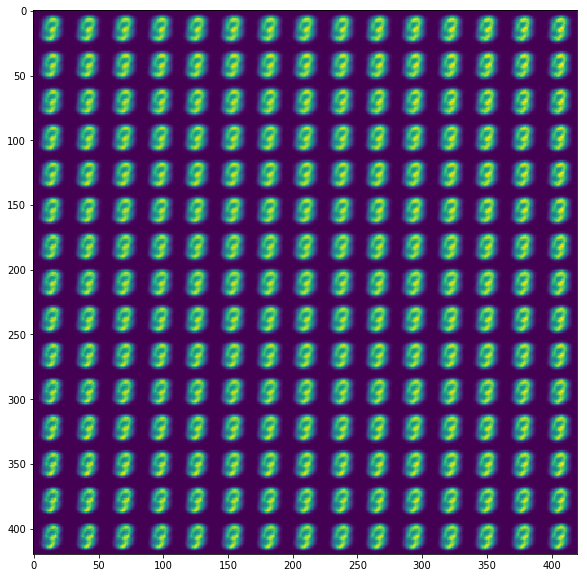

In [91]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()